In [28]:
import torch 
import numpy as np 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from einops import rearrange
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from typing import Tuple, Dict, List, Optional
from types import SimpleNamespace as sn
import subprocess

In [51]:
cfg = sn(
    batch_size = 10_000,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    lr = 1e-3,
)

In [52]:

class Autoencoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int):
        """
        Basic Autoencoder.

        Args:
            input_dim (int): Dimensionality of the input data.
            latent_dim (int): Dimensionality of the latent space representation.
        """
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, input_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the Autoencoder.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Reconstructed input.
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Encode input data to the latent space.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Latent space representation.
        """
        return self.encoder(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Decode latent space representation to the input space.

        Args:
            z (torch.Tensor): Latent space representation.

        Returns:
            torch.Tensor: Reconstructed input.
        """
        return self.decoder(z)


class VAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int):

        super(VAE, self).__init__()
        self.in_dim = input_dim
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean μ of the latent space
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance log(σ^2) of the latent space
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, input_dim)

    def encode(self, x: torch.Tensor):
        """
        Returns:
            A tuple of torch.Tensor: (mean, log variance).
        """
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from q(z|x).

        Args:
            mu (torch.Tensor): Mean of the latent space.
            logvar (torch.Tensor): Log variance of the latent space.

        Returns:
            torch.Tensor: Sampled z.
        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Decode latent variable to reconstruct input.

        Args:
            z (torch.Tensor): Latent variable.

        Returns:
            torch.Tensor: Reconstructed input.
        """
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x: torch.Tensor):
        """
        Forward pass through the VAE.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            A tuple of torch.Tensor: (Reconstructed input, mean, log variance).
        """
        mu, logvar = self.encode(x.view(-1, self.in_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def data(cfg:sn):
    """
    Returns radius, area, and circumference of random circles in batches.
    
    Args:
        batch (int): The number of random circles.
    
    Returns:
        torch.Tensor:
                       The tensor will have a shape of (batch, 3), where each row contains [radius, area, circumference].
    """
    # Generate random radii for the batch
    radius = torch.rand(cfg.batch_size, device=cfg.device)
    
    # Calculate the area for each radius
    area = torch.pi * torch.pow(radius, 2)
    
    # Calculate the circumference for each radius
    circumference = 2 * torch.pi * radius
    
    # Combine radius, area, and circumference into a single tensor for the batch
    combined = torch.stack([radius, area, circumference], dim=1)
    
    return combined


def epoch(objects:sn):
    model, criterion, optimizer, cfg = \
        objects.model, \
        objects.criterion, \
        objects.optimizer, \
        objects.cfg

    x = data(cfg)
    y = model(x)
    loss = criterion(x, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss

def get_objects(cfg):
    criterion = nn.L1Loss()
    model = Autoencoder(3, 1).to(cfg.device)
    optimizer = optim.SGD(model.parameters(), lr=cfg.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        'min', 
        patience=100, 
        factor=0.9, 
        min_lr=1e-6
    )

    objects = sn(
        model = model,
        criterion = criterion,
        optimizer = optimizer,
        scheduler = scheduler,
        cfg = cfg
    )
    return objects



In [69]:
itms = get_objects(cfg)


Epoch 25, Loss: 1.4935, lr: 0.0010
Epoch 50, Loss: 1.4179, lr: 0.0010
Epoch 75, Loss: 1.2916, lr: 0.0010
Epoch 100, Loss: 1.2017, lr: 0.0010
Epoch 125, Loss: 1.1329, lr: 0.0010
Epoch 150, Loss: 1.0786, lr: 0.0010
Epoch 175, Loss: 1.0289, lr: 0.0010
Epoch 200, Loss: 0.9766, lr: 0.0010
Epoch 225, Loss: 0.9005, lr: 0.0010
Epoch 250, Loss: 0.7171, lr: 0.0010
Epoch 275, Loss: 0.4687, lr: 0.0010
Epoch 300, Loss: 0.3196, lr: 0.0010
Epoch 325, Loss: 0.2616, lr: 0.0010
Epoch 350, Loss: 0.2207, lr: 0.0010
Epoch 375, Loss: 0.1879, lr: 0.0010
Epoch 400, Loss: 0.1586, lr: 0.0010
Epoch 425, Loss: 0.1344, lr: 0.0010
Epoch 450, Loss: 0.1200, lr: 0.0010
Epoch 475, Loss: 0.1124, lr: 0.0010


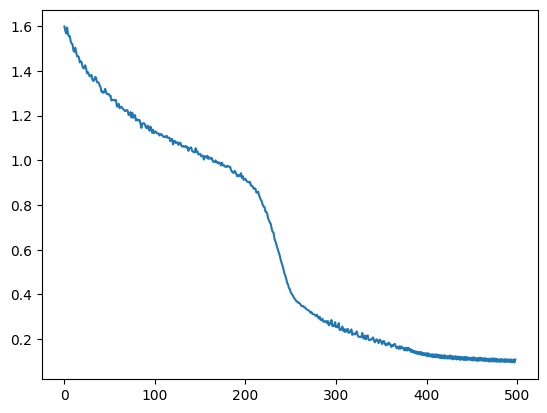

In [76]:
losses = []

for i in range(1,500):
    l = epoch(itms)  
    losses.append(l.item())
    if i % 25 == 0:
        print(f"Epoch {i}, Loss: {np.mean(losses[-50:]):.4f}, lr: {itms.optimizer.param_groups[0]['lr']:.4f}")

plt.plot(losses)

Epoch 25, Loss: 0.0649, lr: 0.0010
Epoch 50, Loss: 0.0654, lr: 0.0010
Epoch 75, Loss: 0.0651, lr: 0.0010
Epoch 100, Loss: 0.0650, lr: 0.0010
Epoch 125, Loss: 0.0651, lr: 0.0010
Epoch 150, Loss: 0.0648, lr: 0.0010
Epoch 175, Loss: 0.0641, lr: 0.0010
Epoch 200, Loss: 0.0639, lr: 0.0010
Epoch 225, Loss: 0.0640, lr: 0.0010
Epoch 250, Loss: 0.0636, lr: 0.0010
Epoch 275, Loss: 0.0632, lr: 0.0010
Epoch 300, Loss: 0.0633, lr: 0.0010
Epoch 325, Loss: 0.0629, lr: 0.0010
Epoch 350, Loss: 0.0624, lr: 0.0010
Epoch 375, Loss: 0.0624, lr: 0.0010
Epoch 400, Loss: 0.0625, lr: 0.0010
Epoch 425, Loss: 0.0625, lr: 0.0010
Epoch 450, Loss: 0.0620, lr: 0.0010
Epoch 475, Loss: 0.0619, lr: 0.0010
Epoch 500, Loss: 0.0616, lr: 0.0010
Epoch 525, Loss: 0.0612, lr: 0.0010
Epoch 550, Loss: 0.0611, lr: 0.0010
Epoch 575, Loss: 0.0610, lr: 0.0010
Epoch 600, Loss: 0.0609, lr: 0.0010
Epoch 625, Loss: 0.0608, lr: 0.0010
Epoch 650, Loss: 0.0608, lr: 0.0010
Epoch 675, Loss: 0.0608, lr: 0.0010
Epoch 700, Loss: 0.0605, lr: 0.

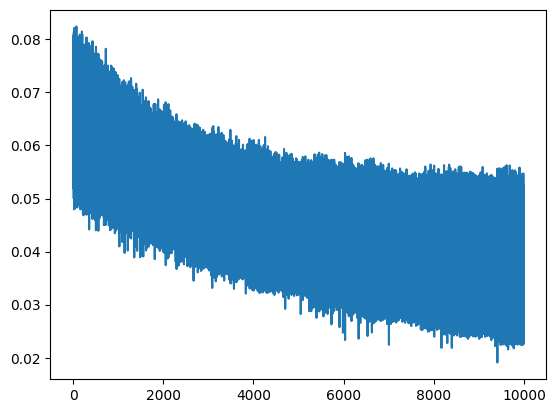

In [61]:
losses = []

for i in range(1,10000):
    l = epoch(itms)  
    losses.append(l.item())
    if i % 25 == 0:
        print(f"Epoch {i}, Loss: {np.mean(losses[-50:]):.4f}, lr: {itms.optimizer.param_groups[0]['lr']:.4f}")

plt.plot(losses)

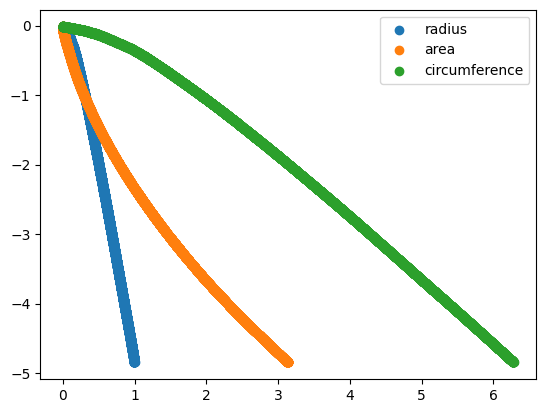

In [77]:
x = data(cfg)
y = itms.model.encode(x)
rad, area, circ = x[:,0], x[:,1], x[:,2]
#plot relationship between radius and y

plt.scatter(rad.cpu().numpy(), y.cpu().detach().numpy())
plt.scatter(area.cpu().numpy(), y.cpu().detach().numpy())
plt.scatter(circ.cpu().numpy(), y.cpu().detach().numpy())
plt.legend(['radius', 'area', 'circumference'])
plt.show()

In [78]:
#regress rad on y


reg = LinearRegression().fit(rad.cpu().numpy().reshape(-1, 1), y.cpu().detach().numpy().reshape(-1, 1))

y_pred = reg.predict(rad.cpu().numpy().reshape(-1, 1))

print(mean_squared_error(y.cpu().detach().numpy().reshape(-1, 1), y_pred))


0.016653804


In [79]:
itms.model.decode(torch.tensor([0.5], device=cfg.device))

tensor([-0.0321, -0.0393,  1.0395], device='cuda:0', grad_fn=<ViewBackward0>)